<!---
The MIT License (MIT)

Copyright (c) 2016 Sean UN Wood

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
--->

# Offline Blind Speech Enhancement with GCC-NMF

#### Sean UN Wood, August 2017

## Abstract

This **iPython Notebook** presents a demo of the offline speech enhancement algorithm presented in:

- Sean UN Wood, Jean Rouat, Stéphane Dupont, Gueorgui Pironkov, [*Blind Speech Separation and Enhancement with GCC-NMF*](https://www.gel.usherbrooke.ca/rouat/publications/IEEE_ACMTrGCCNMFWoodRouat2017.pdf), **IEEE/ACM Transactions on Audio, Speech, and Language Processing**, vol. 25, no. 4, pp. 745–755, 2017.  
DOI: [10.1109/TASLP.2017.2656805](https://doi.org/10.1109/TASLP.2017.2656805)

We follow the same structure as the offline [blind speech separation with GCC-NMF]() demo presented previously. Speech enhancement is performed directly on the stereo mixture signal using no additional data:
- An NMF dictionary is first learned from the left and right mixture spectrograms, concatenated *in time*.
- Dictionary atoms are then attributed either to the target speaker or to background noise, at each point in time, according to their time difference of arrival (TDOA) estimates. This defines a binary NMF coefficient mask.
- Masked coefficients are then used to reconstruct the target speaker.

This demo enhances the speech from the *data/dev_Sq1_Co_A_mix.wav* mixture, taken from the [SiSEC 2016 Two-channel mixtures of speech and real-world background noise](https://sisec.inria.fr/home/bgn-2016/) "dev" dataset, and saves results to the *data* directory.

## Overview
1. Preliminary setup
2. Input mixture signal
3. Complex mixture spectrogram
4. GCC-PHAT source localization
5. NMF decomposition
6. GCC-NMF coefficient mask generation
7. Target spectrogram estimate reconstruction
8. Target signal estimates reconstruction

# 1. Preliminary setup
#### Python imports

In [1]:
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *

from IPython import display

%matplotlib inline

#### Parameter definitions

In [2]:
# Preprocessing params
windowSize = 1024
fftSize = windowSize
hopSize = 128
windowFunction = hanning

# TDOA params
numTDOAs = 128
targetTDOAWindowSizePercent = 0.05

# NMF params
dictionarySize = 128
numIterations = 100
sparsityAlpha = 0

# Input params    
mixtureFileNamePrefix = '../data/dev_Sq1_Co_A'
microphoneSeparationInMetres = 0.086
numSources = 1

hypothesisTDOAs = getTDOAsInSeconds(microphoneSeparationInMetres, numTDOAs)
targetTDOAWindowSize = (hypothesisTDOAs[-1] - hypothesisTDOAs[0]) * targetTDOAWindowSizePercent

# 2. Input mixture signal

#### Load mixture signal from the wav file

In [3]:
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)

numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)

#### Plot mixture signal

Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


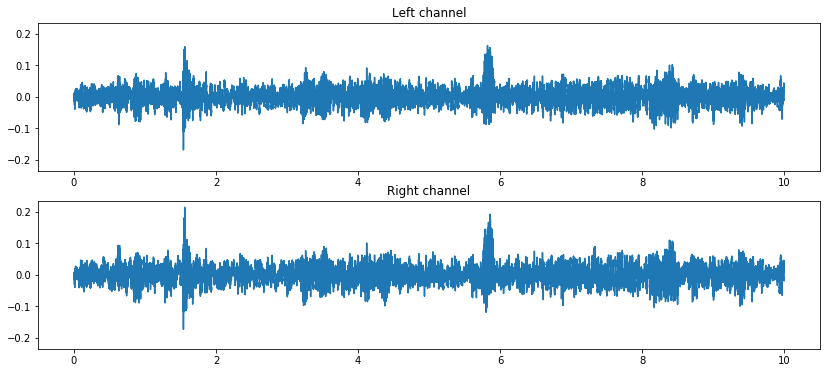

In [4]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

display.display( display.Audio(mixtureFileName) )

# 3. Complex mixture spectrogram

#### Compute complex mixture spectrograms from input signal with an STFT

In [5]:
complexMixtureSpectrogram = computeComplexMixtureSpectrogram( stereoSamples, windowSize,
                                                              hopSize, windowFunction ) 
numChannels, numFrequencies, numTime = complexMixtureSpectrogram.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

#### Plot magnitude mixture spectrograms

STFT:
	windowSize: 1024
	hopSize: 128
	windowFunction: <function hanning at 0x10d683d90>
	complexMixtureSpectrogram.shape = (numChannels, numFreq, numWindows): (2, 513, 1243)
	complexMixtureSpectrogram.dtype = complex64


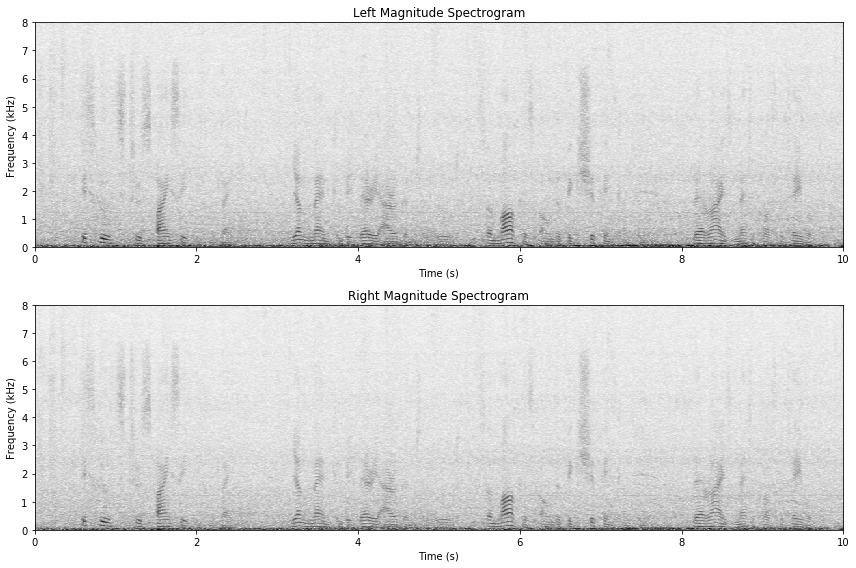

In [6]:
describeMixtureSpectrograms(windowSize, hopSize, windowFunction, complexMixtureSpectrogram)

figure(figsize=(12, 8))
plotMixtureSpectrograms(complexMixtureSpectrogram, frequenciesInkHz, durationInSeconds)

# 4. Perform source localization with GCC-PHAT

#### Estimate target TDOA

In [7]:
spectralCoherenceV = complexMixtureSpectrogram[0] * complexMixtureSpectrogram[1].conj() \
                     / abs(complexMixtureSpectrogram[0]) / abs(complexMixtureSpectrogram[1])
angularSpectrogram = getAngularSpectrogram( spectralCoherenceV, frequenciesInHz,
                                            microphoneSeparationInMetres, numTDOAs )
meanAngularSpectrum = mean(angularSpectrogram, axis=-1) 
targetTDOAIndexes = estimateTargetTDOAIndexesFromAngularSpectrum( meanAngularSpectrum,
                                                                  microphoneSeparationInMetres,
                                                                  numTDOAs, numSources)
targetTDOAIndex = targetTDOAIndexes[0]
targetTDOA = hypothesisTDOAs[targetTDOAIndex]

#### Plot target localization

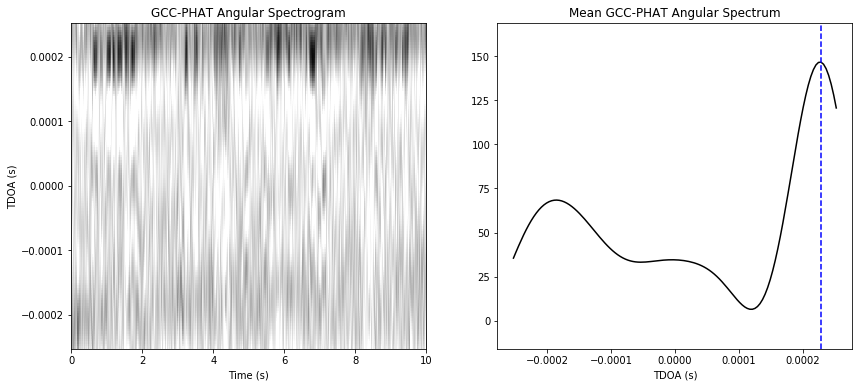

In [8]:
figure(figsize=(14, 6))
plotGCCPHATLocalization( spectralCoherenceV, angularSpectrogram, meanAngularSpectrum,
                         targetTDOAIndexes, microphoneSeparationInMetres, numTDOAs,
                         durationInSeconds )

# 5. Perform NMF decomposition of mixture spectrograms

#### Compute NMF decomposition, with left and right magnitude spectrograms concatenated *in time*

In [9]:
V = concatenate( abs(complexMixtureSpectrogram), axis=-1 )
W, H = performKLNMF(V, dictionarySize, numIterations, sparsityAlpha)

numChannels = stereoSamples.shape[0]
stereoH = array( hsplit(H, numChannels) )

#### Plot NMF decomposition

Input V:
    V.shape = (numFreq, numWindows): (513, 2486)
    V.dtype = float32
Dictionary W:
    W.shape = (numFreq, numAtoms): (513, 128)
    W.dtype = float32
Coefficients H:
    H.shape = (numAtoms, numWindows): (128, 2486)
    H.dtype = float32


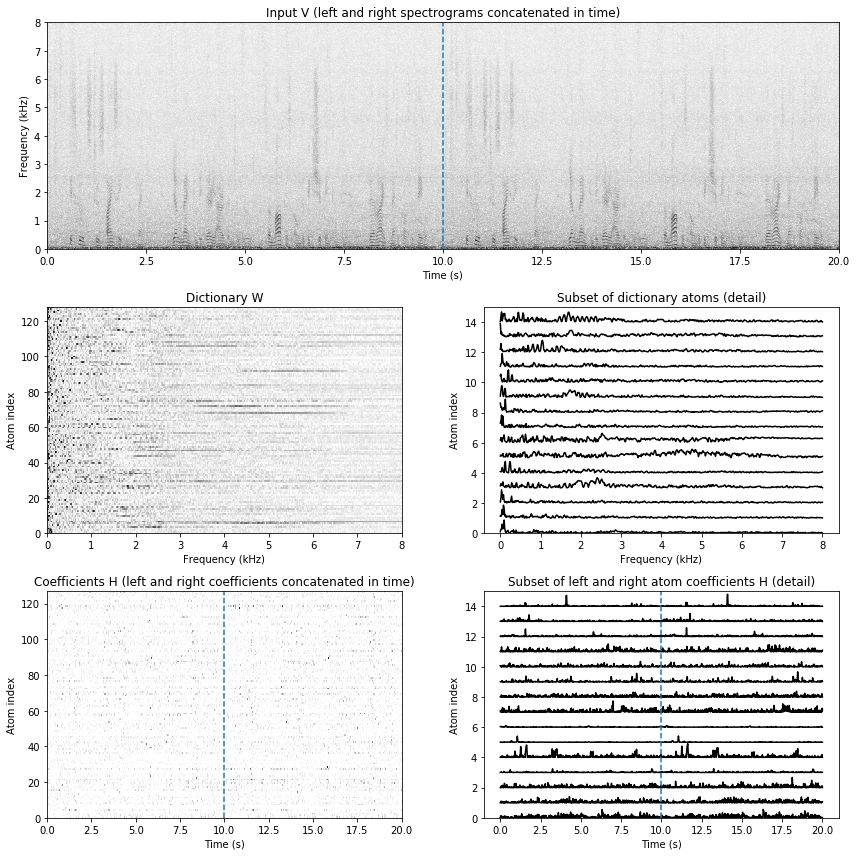

In [10]:
describeNMFDecomposition(V, W, H)

figure(figsize=(12, 12))
plotNMFDecomposition(V, W, H, frequenciesInkHz, durationInSeconds, numAtomsToPlot=15)

# 6. Compute GCC-NMF target coefficient mask

#### Compute GCC-NMF angular spectrograms for each dictionary atom

In [11]:
expJOmegaTau = exp( outer(frequenciesInHz, -(2j * pi) * hypothesisTDOAs) )

gccNMFs = []
for frameIndex in range(numTime):
    gccNMF = dot( (spectralCoherenceV[:, frameIndex, newaxis] * expJOmegaTau).real.T, W )
    gccNMFs.append(gccNMF)
gccNMF = array(gccNMFs).T

#### Compute NMF coefficient mask for the target speaker

In [12]:
argMaxGCCNMF = argmax(gccNMF, axis=1)
gccNMFMaxTDOA = np.take(hypothesisTDOAs, argMaxGCCNMF)
distanceToTargetTDOA = abs(gccNMFMaxTDOA - targetTDOA)
targetCoefficientMask = distanceToTargetTDOA < targetTDOAWindowSize
targetCoefficientMasks = array([targetCoefficientMask])

#### Plot results:
- a) GCC-NMF maximum TDOA for each NMF atom
- b) Distance between these maximum TDOAs and the target TDOA
- c) Resulting coefficient mask, given the defined target TDOA distance, i.e. targetTDOAWindowSize

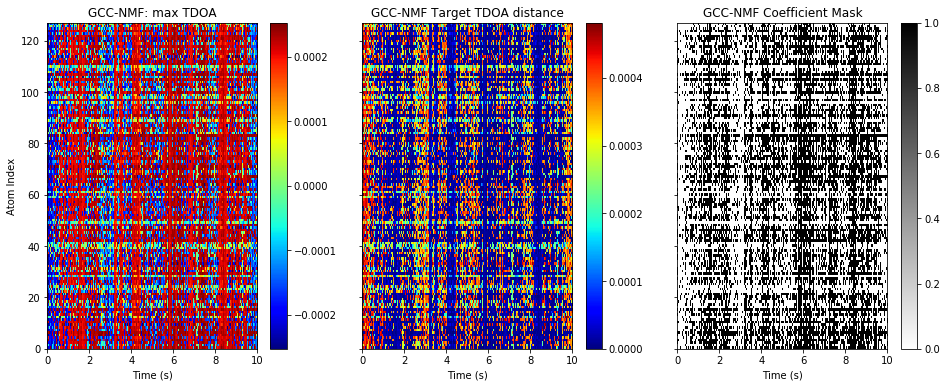

In [13]:
figure(figsize=(16, 6))
subplot(131)
imshow( gccNMFMaxTDOA, cmap=cm.jet, extent=[0, durationInSeconds, 0, dictionarySize-1])
colorbar()
ylabel('Atom Index')
title('GCC-NMF: max TDOA')
xlabel('Time (s)')

ax = subplot(132)
imshow( distanceToTargetTDOA, cmap=cm.jet, extent=[0, durationInSeconds, 0, dictionarySize-1])
colorbar()
title('GCC-NMF Target TDOA distance')
xlabel('Time (s)')
ax.set_yticklabels([])

ax = subplot(133)
imshow(targetCoefficientMask, cmap=cm.binary, extent=[0, durationInSeconds, 0, dictionarySize-1])
colorbar()
title('GCC-NMF Coefficient Mask')
xlabel('Time (s)')
ax.set_yticklabels([])

show()

#### Plot resulting masked coefficients for each channel

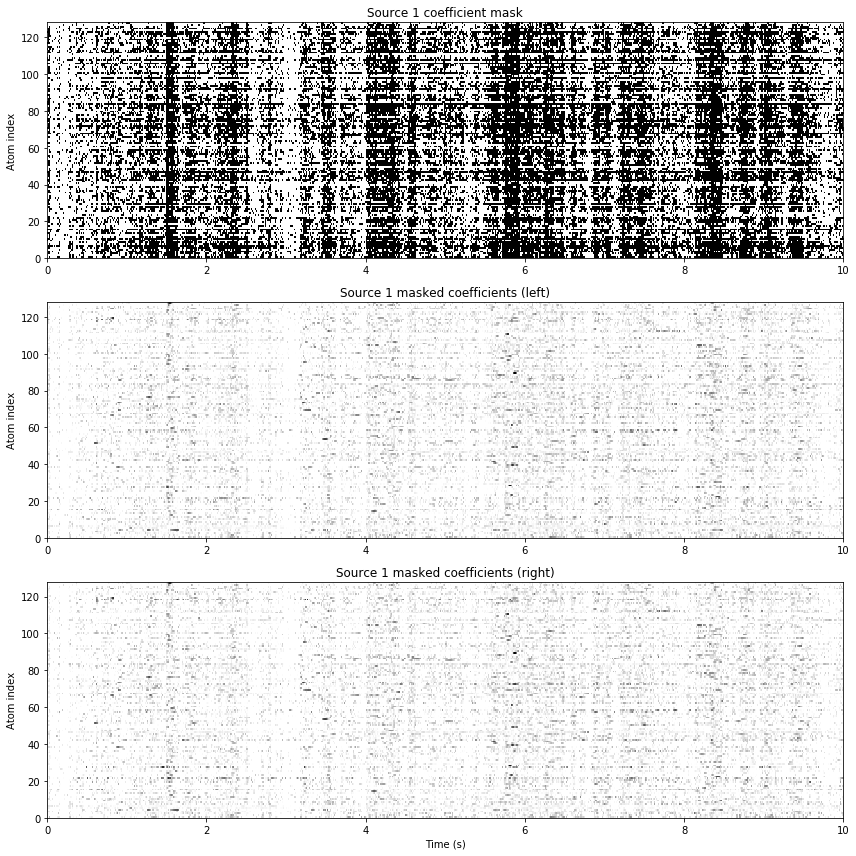

In [14]:
figure(figsize=(12, 12))
plotCoefficientMasks(targetCoefficientMasks, stereoH, durationInSeconds)

# 7. Reconstruct target spectrogram estimates

#### Reconstruct target spectrogram estimate using masked NMF coefficients, for each channel

In [15]:
targetSpectrogramEstimates = getTargetSpectrogramEstimates( targetCoefficientMasks,
                                                            complexMixtureSpectrogram, W,
                                                            stereoH )

#### Plot reconstructed target estimate spectrograms

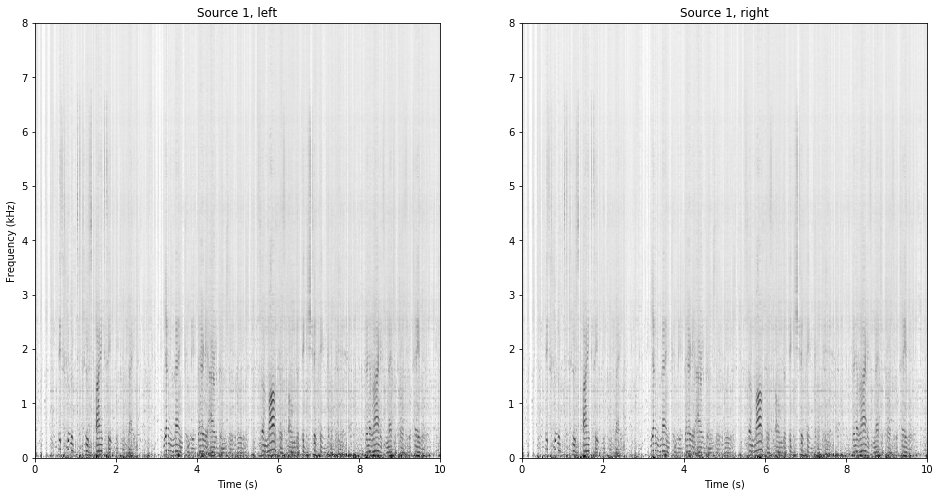

In [16]:
figure(figsize=(16, 8))
plotTargetSpectrogramEstimates(targetSpectrogramEstimates, durationInSeconds, frequenciesInkHz)

# 8. Reconstruct time domain target signal estimates

#### Combine source estimate spectrograms with the input mixture spectrogram's phase, and perform the inverse STFT

In [17]:
targetSignalEstimates = getTargetSignalEstimates( targetSpectrogramEstimates, windowSize,
                                                  hopSize, windowFunction )
saveTargetSignalEstimates(targetSignalEstimates, sampleRate, mixtureFileNamePrefix)

#### Plot time domain source signal estimates, and compare with original mixture

Input Mixture


Target Estimate


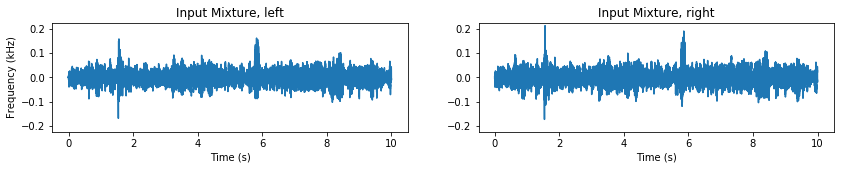

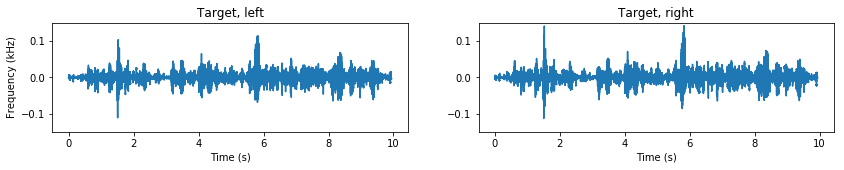

In [18]:
figure(figsize=(14, 2))
plotTargetSignalEstimate(stereoSamples, sampleRate, 'Input Mixture')

figure(figsize=(14, 2))
targetFileName = getSourceEstimateFileName(mixtureFileNamePrefix, 0)
plotTargetSignalEstimate( targetSignalEstimates[0], sampleRate, 'Target' )

print('Input Mixture')
display.display( display.Audio(mixtureFileName) )

print('Target Estimate')
display.display(display.Audio(targetFileName))

### Finally
The trade-off between noise suppression and target fidelity may be controlled via the *targetTDOAWindowSizePercent* variable...